In [1]:
import networkx as nx
import numpy as np
from collections import defaultdict
from copy import copy
from copy import deepcopy
from dataclasses import dataclass
from itertools import combinations
from itertools import product
from matplotlib import pyplot as plt
from matplotlib import patches as ptch
from operator import itemgetter
from random import randint
from scipy.optimize import linprog
from statistics import median
from typing import Any
from typing import Callable
from typing import ClassVar
from typing import Dict
from typing import Generator
from typing import List
from typing import NoReturn
from typing import Optional
from typing import Set
from typing import Tuple

In [2]:
global_x_min: int = 0
global_x_max: int = 500
global_y_min: int = 0
global_y_max: int = 500
min_width:    int = 10
max_width:    int = 100
min_height:   int = 10
max_height:   int = 100
min_n_recs:   int = 3
max_n_recs:   int = 12
step_n_recs:  int = 1

In [3]:
@dataclass
class Point:
    x: int
    y: int


@dataclass
class Rectangle:
    label:  Point
    begins: List[Point]  # 1 <= len(begins) <= 2
    width:  int
    height: int

## Вспомогательная функция для проверки пересечения прямоугольников

In [4]:
def no_crossing(lrec: Rectangle, 
                lind: int, 
                rrec: Rectangle, 
                rind: int) -> bool:
    lbegin: int = lrec.begins[lind]
    lx_min: int = lbegin.x
    lx_max: int = lbegin.x + lrec.width
    ly_min: int = lbegin.y
    ly_max: int = lbegin.y + lrec.height
    
    rbegin: int = rrec.begins[rind]
    rx_min: int = rbegin.x
    rx_max: int = rbegin.x + rrec.width
    ry_min: int = rbegin.y
    ry_max: int = rbegin.y + rrec.height
    
    rx_crossing: bool = lx_min < rx_min < lx_max or lx_min < rx_max < lx_max
    lx_crossing: bool = rx_min < lx_min < rx_max or rx_min < lx_max < rx_max
    x_crossing:  bool = rx_crossing or lx_crossing
    
    ry_crossing: bool = ly_min < ry_min < ly_max or ly_min < ry_max < ly_max
    ly_crossing: bool = ry_min < ly_min < ry_max or ry_min < ly_max < ry_max
    y_crossing:  bool = ry_crossing or ly_crossing
        
    return not(x_crossing and y_crossing)

## Вспомогательные функции генерации тестовых данных

In [5]:
def generate_rectangle() -> Rectangle:
    width:  int       = randint(min_width, max_width)
    height: int       = randint(min_height, max_height)
    label:  Point     = Point(x=randint(global_x_min+1, global_x_max-1), 
                              y=randint(global_y_min+1, global_y_max-1))
    rectangle: Rectangle = Rectangle(label=label,
                                     begins=[],
                                     width=width,
                                     height=height)
    begins_cnt: int = 0
    while begins_cnt < 2:
        begin: Point = Point(x=randint(label.x-width, label.x), 
                             y=randint(label.y-height, label.y))
        if global_x_min <= begin.x <= global_x_max and \
            global_y_min <= begin.y <= global_y_max and \
            global_x_min <= begin.x + width <= global_x_max and \
            global_y_min <= begin.y + height <= global_y_max:
            begins_cnt += 1
            rectangle.begins.append(begin)
    
    return rectangle

In [6]:
def rectangle_generator(num_recs: int = 1) -> Generator:
    for _ in range(num_recs):
        yield generate_rectangle()

## Функция для отрисовки меток

In [7]:
def draw(rectangles: List[Rectangle]) -> NoReturn:
    fig, ax = plt.subplots(figsize=(16, 9))
    plt.xlim(global_x_min, global_x_max)
    plt.ylim(global_y_min, global_y_max)
    
    for rectangle in rectangles:
        for begin in rectangle.begins:
            rect = ptch.Rectangle(xy=(begin.x, begin.y), 
                                  width=rectangle.width, 
                                  height=rectangle.height, 
                                  linewidth=1, 
                                  edgecolor='black', 
                                  facecolor=np.random.rand(3,), 
                                  alpha=0.2)
            ax.add_patch(rect)

        ax.plot(
            [rectangle.label.x], 
            [rectangle.label.y], 
            marker='o', 
            markersize=10, 
            color="red"
        )
    
    plt.title(f"Number of labels: {len(rectangles)}")
    plt.show()

## Сгенеррируем тестовые данные

In [8]:
test_cases: List[List[Rectangle]] = list(
    list(rectangle_generator(n_labels)) 
    for n_labels in range(min_n_recs, max_n_recs, step_n_recs)
)

## Посмотрим на данные с которыми нам придется работать. Подписи отображены в двух вариантах расположения.

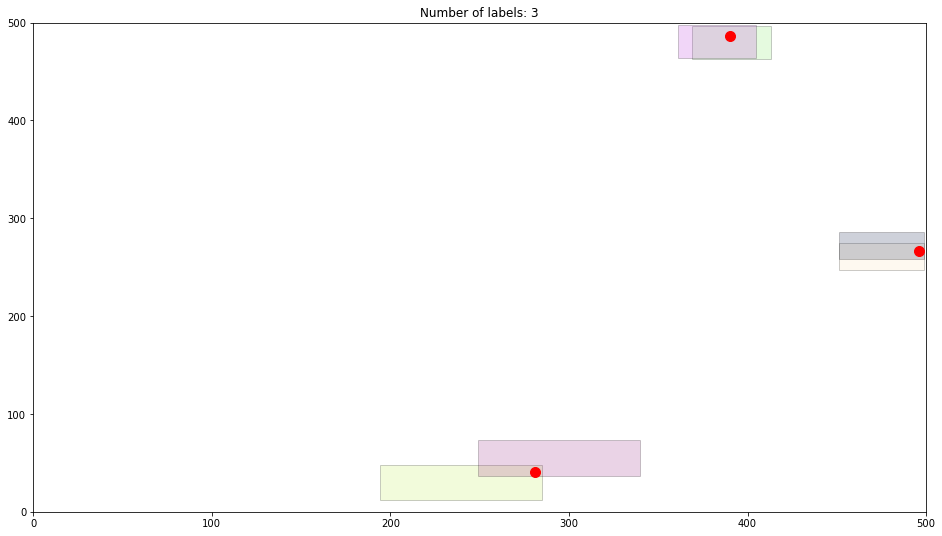

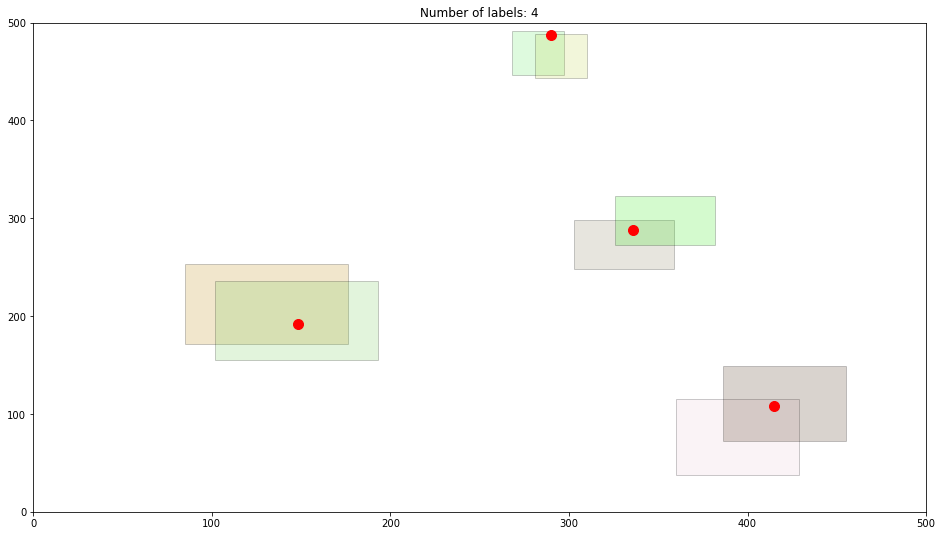

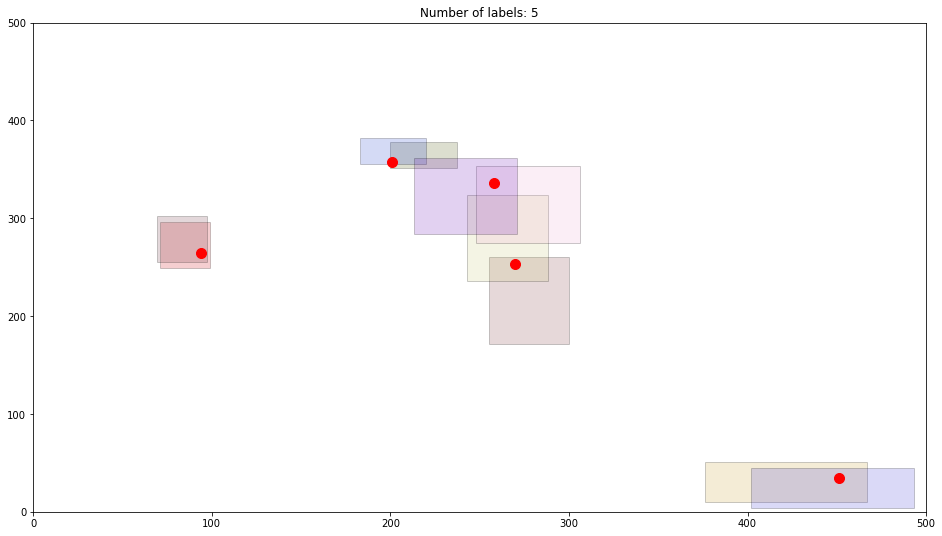

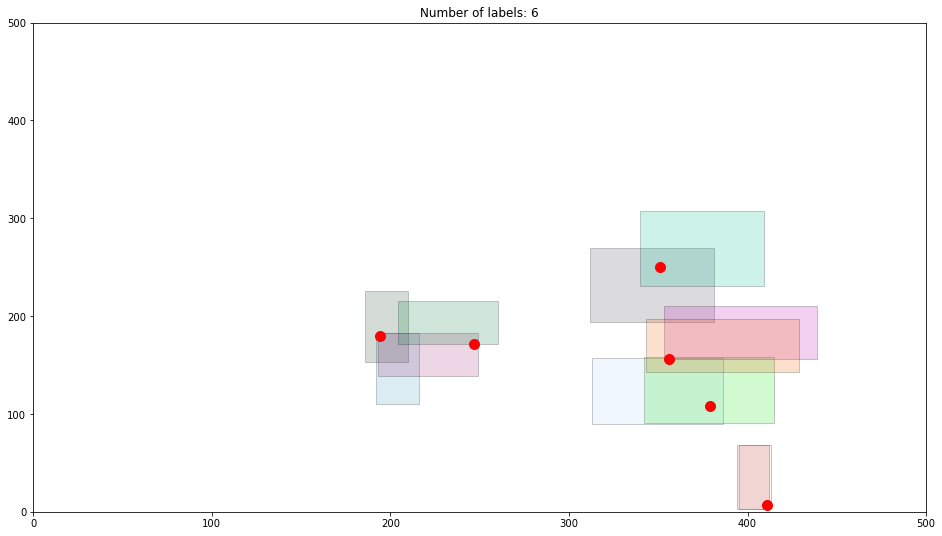

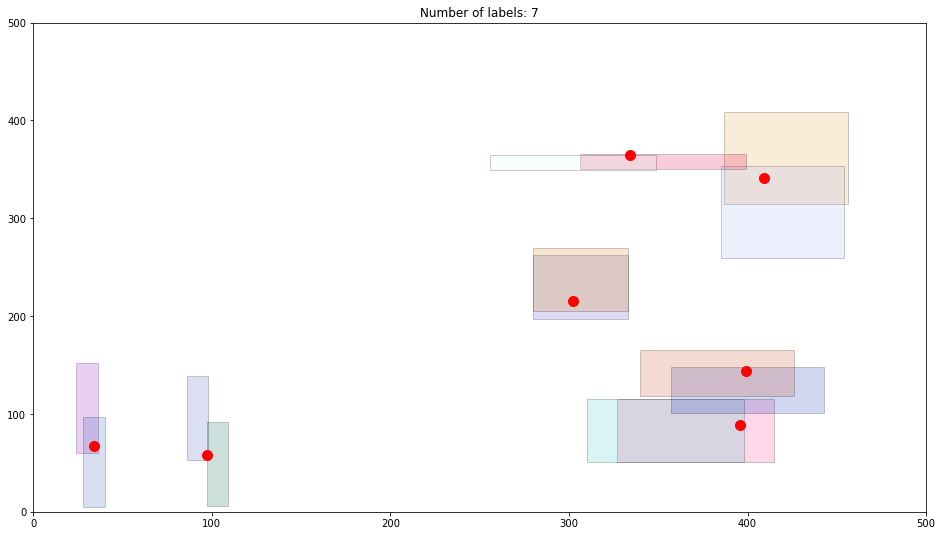

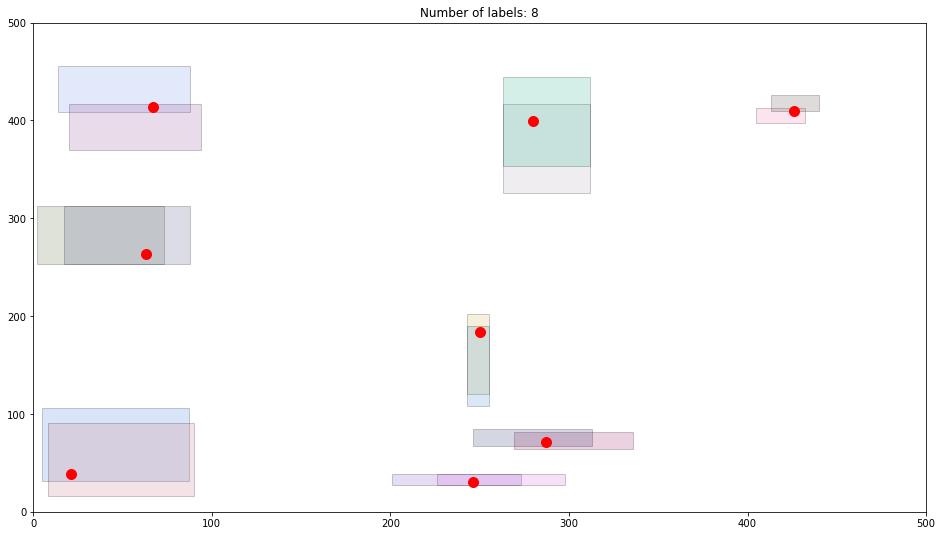

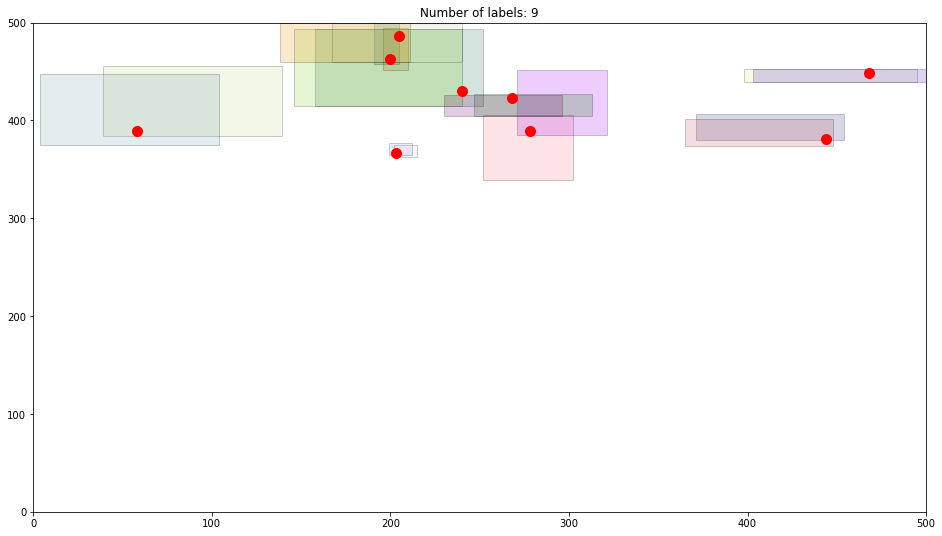

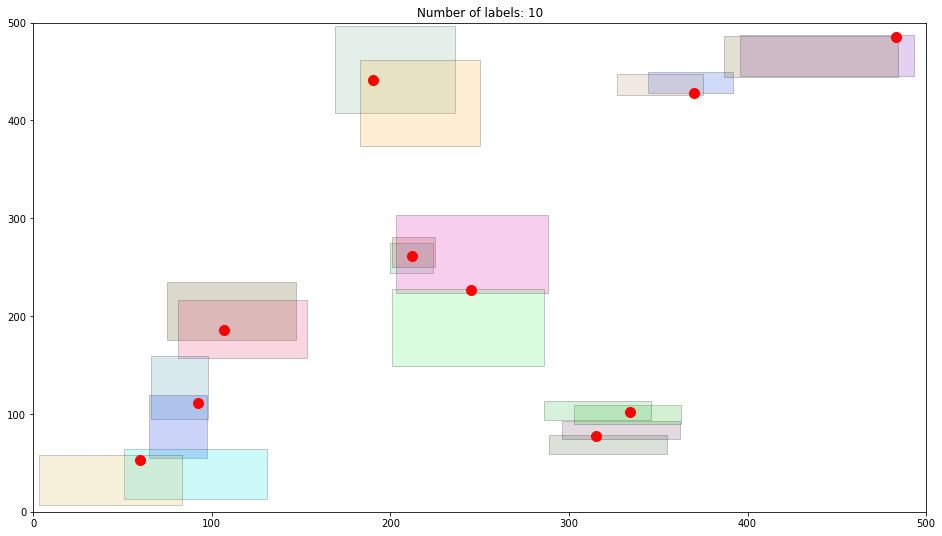

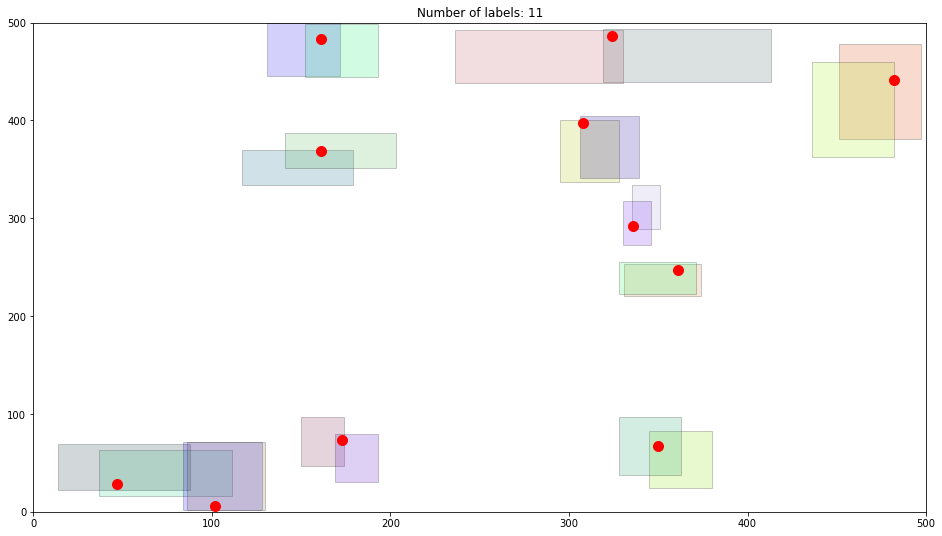

In [9]:
for test_case in test_cases:
    draw(test_case)

## Класс для укладки подписей

In [10]:
class LabelLayer:
    def __init__(self, data: List[Rectangle]):
        self.data:  List[Rectangle] = data
        self.graph: nx.DiGraph      = nx.DiGraph()
        for node in range(len(data)):
            self.graph.add_node((node, 0))
            self.graph.add_node((node, 1))
        for rec_from, rec_to in combinations(range(len(data)), 2):
            for from_ind, to_ind in product([0, 1], repeat=2):
                if not no_crossing(data[rec_from], from_ind, data[rec_to], to_ind):
                    self.graph.add_edge((rec_from, from_ind), (rec_to, 1 - to_ind))
                    self.graph.add_edge((rec_to, to_ind), (rec_from, 1 - from_ind))
                    self.graph.add_edge((rec_to, 1 - to_ind), (rec_from, from_ind))
                    self.graph.add_edge((rec_from, 1 - from_ind), (rec_to, to_ind))
        self.rev_graph: nx.DiGraph = self.graph.reverse(copy=True)
            
    def lay_down(self) -> List[Rectangle]:
        used:          Dict[Tuple[int, int], bool] = {}
        topsort_order: List[Tuple[int, int]]       = []
        for vertex in self.graph.nodes:
            if vertex not in used:
                self.forward_dfs(vertex, used, topsort_order)

        components: Dict[Tuple[int, int], int] = {}
        cluster:    int                        = 0
        for vertex in reversed(topsort_order):
            if vertex not in components:
                self.backward_dfs(vertex, cluster, components)
                cluster += 1

        if not self.check_consistency(components):
            return []
            
        answer: List[RectangleRectangle] = []
        for i, rectangle in enumerate(self.data):
            begin_ind = 1 if components[(i, 0)] > components[(i, 1)] else 0
            answer.append(Rectangle(label=self.data[i].label,
                                    begins=[self.data[i].begins[begin_ind]],
                                    width=self.data[i].width,
                                    height=self.data[i].height))
        return answer
            
    def check_consistency(self, 
                          components: Dict[Tuple[int, int], int]) -> NoReturn:
        by_literal: Dict[int, Set[int]] = defaultdict(set)
        for literal in self.graph.nodes:
            by_literal[literal[0]].add(components[literal])
        for n_components in by_literal.values():
            if len(n_components) == 1:
                return False
        return True
            
    def forward_dfs(self, 
                    vertex: int, 
                    used: Dict[Tuple[int, int], bool], 
                    topsort_order: List[Tuple[int, int]]) -> NoReturn:
        used[vertex] = True
        for to in self.graph.successors(vertex):
            if to not in used:
                self.forward_dfs(to, used, topsort_order)
        topsort_order.append(vertex)
        
    def backward_dfs(self, 
                     vertex: Tuple[int, int], 
                     cluster: int, 
                     components: Dict[Tuple[int, int], int]) -> NoReturn:
        components[vertex] = cluster
        for to in self.rev_graph.successors(vertex):
            if to not in components:
                self.backward_dfs(to, cluster, components)

## Воспользуемся нашим классом для укладки

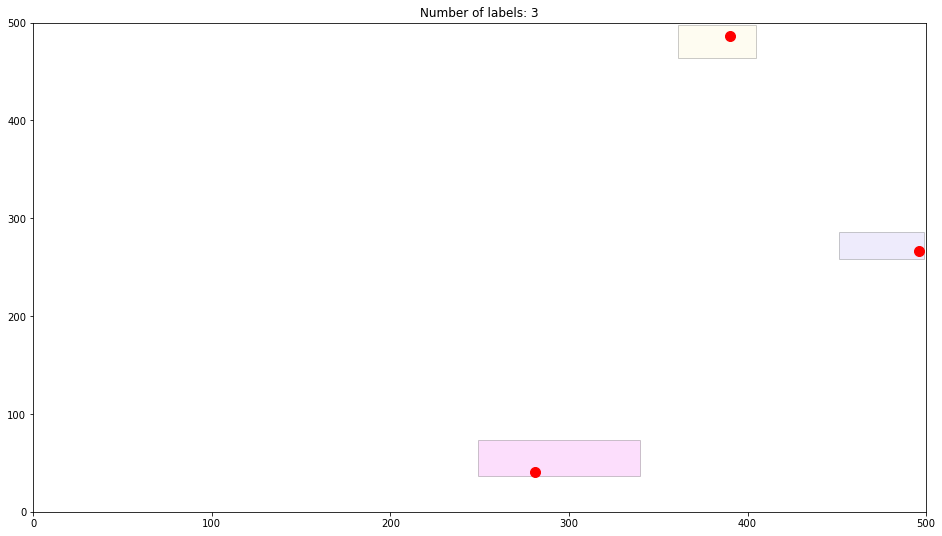

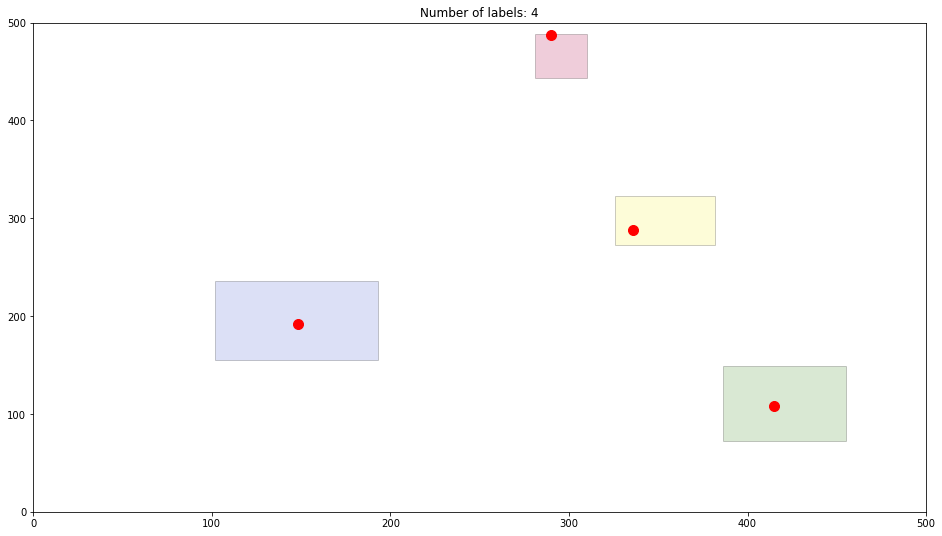

No solution
No solution
No solution


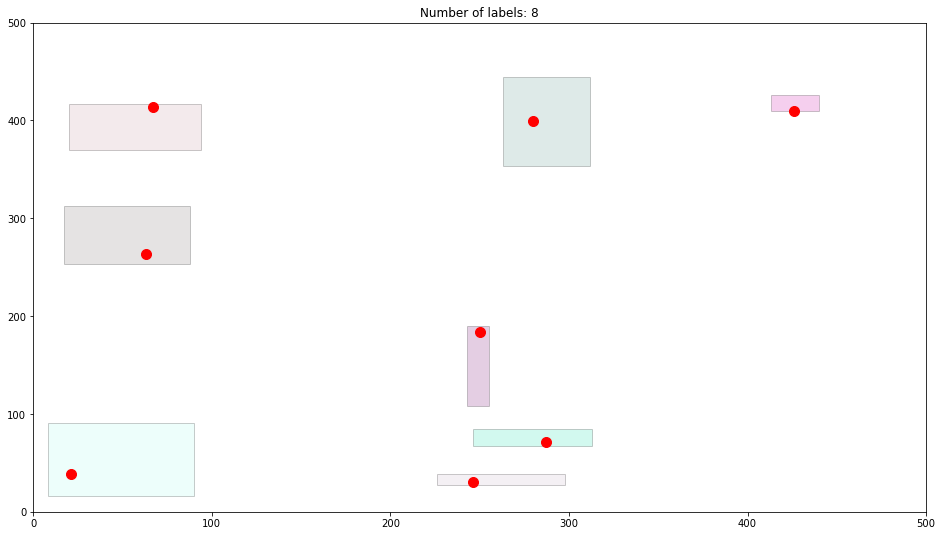

No solution
No solution
No solution


In [11]:
for test_case in test_cases:
    layer:      LabelLayer      = LabelLayer(test_case)
    rectangles: List[Rectangle] = layer.lay_down()
    if rectangles: 
        draw(rectangles)
    else:
        print("No solution")